In [1]:
import os
import glob
import numpy as np
import duckdb
import pandas as pd
from matplotlib import pyplot as plt
import itertools

In [2]:
# directory the data was downloaded to locally
data_dir = './xdd_parquet'

Use ranges of previous experiments to classify realization flows

In [3]:
generated_flows_wider = np.load('LHsamples_wider_100_AnnQonly_flows.npy')
samples = pd.read_csv('LHsamples_wider_100_AnnQonly.txt', header=0, delim_whitespace=True)

CMIP_flows = np.load('CMIP_SOWs_flows.npy')
historic_flows = np.load('historic_flows.npy')
stationary_flows = np.load('stationarysynthetic_flows.npy')

Convert to metric and calculate mins and maxs

In [4]:
data = [generated_flows_wider, CMIP_flows, stationary_flows]
data_metric = [x*1233.4818 for x in data]
data_mins = [np.min(np.min(dataset, axis=0), axis=0) for dataset in data_metric]
data_maxs = [np.max(np.max(dataset, axis=0), axis=0) for dataset in data_metric]

historic_mins = np.min(historic_flows*1233.4818, axis=0)
historic_maxs = np.max(historic_flows*1233.4818, axis=0)

Set styles for each experiment dataset

In [5]:
colors = ['#9597a3', '#305252', '#D0CD94','#156796']
labels = ['All encompassing', 'CMIP5 & CMIP3', 'Stationary synthetic', 'Historic']

Show ranges for each experiment

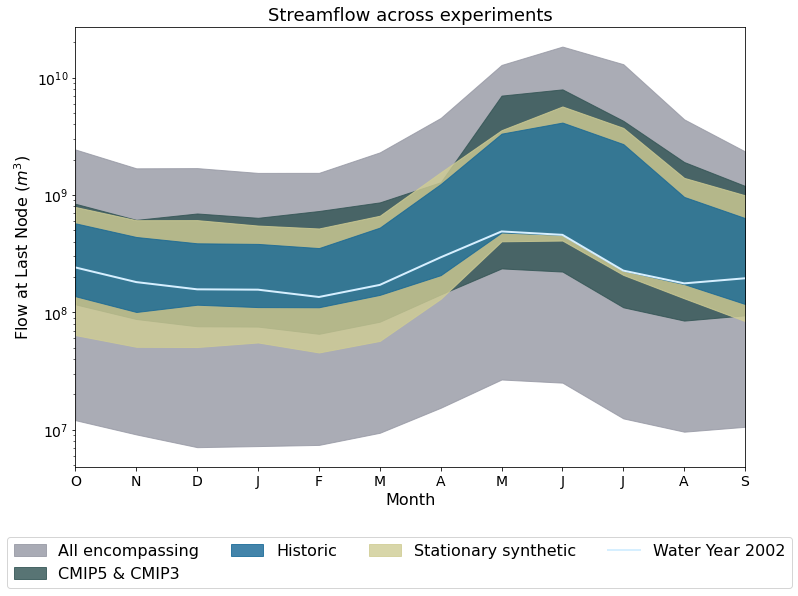

In [6]:
fig = plt.figure(figsize=(12, 9))
ax1 = fig.add_subplot(111)
for i in range(len(data)):
    ax1.fill_between(range(12), data_mins[i],
                     data_maxs[i], color=colors[i],
                     label=labels[i], alpha=0.8)
ax1.fill_between(range(12), historic_mins,
                 historic_maxs, color=colors[3],
                 label=labels[3], alpha=0.8)
ax1.plot(range(12), historic_flows[93,:]*1233.4818, color='#D6EFFF', linewidth = 2, label='Water Year 2002')
ax1.set_yscale("log")
ax1.set_xlabel('Month', fontsize=16)
ax1.set_ylabel('Flow at Last Node ($m^3$)', fontsize=16)
ax1.set_xlim([0, 11])
ax1.tick_params(axis='both', labelsize=14)
ax1.set_xticks(range(12))
ax1.set_xticklabels(['O','N','D','J','F','M','A','M','J','J','A','S'])
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
fig.subplots_adjust(bottom=0.2)
fig.legend(handles, labels, fontsize=16, loc='lower center', ncol=4)
ax1.set_title('Streamflow across experiments',fontsize=18)
plt.savefig('streamflows.svg')
plt.show()

Classify flows

In [ ]:
flows_classification = []

In [ ]:
fig = plt.figure(figsize=(12, 9))
ax2 = fig.add_subplot(111)
generated_flows_flat = generated_flows_wider.reshape(1000*105, 12)*1233.4818
for j in range(len(generated_flows_flat)):
    #check if flows lay within experiment ranges, loop through datasets in reverse order
    for k in range(2, -1, -1):
        zipped_list = list(zip(generated_flows_flat[j, :], data_mins[k], data_maxs[k]))
        boolean_list = [True if monthly_value[0] >= monthly_value[1] and monthly_value[0] <= monthly_value[2] \
                            else False for monthly_value in zipped_list]
        if all(boolean_list):
            flows_classification.append(k)
            color = colors[k]
            ax2.plot(range(12), generated_flows_flat[j, :], color=color, alpha=0.1)
            break
ax2.set_yscale("log")
ax2.set_xlabel('Month', fontsize=16)
ax2.set_ylabel('Flow at Last Node ($m^3$)', fontsize=16)
ax2.set_xlim([0, 11])
ax2.tick_params(axis='both', labelsize=14)
ax2.set_xticks(range(12))
ax2.set_xticklabels(['O','N','D','J','F','M','A','M','J','J','A','S'])
plt.show()

Calculate all annual flows in sample

In [73]:
annual_flows = np.sum(generated_flows_wider, axis=2)

Identify reference flow conditions

In [74]:
annual_historic_flows = np.sum(historic_flows, axis=1)

reference_bad_flow = annual_historic_flows[93]

reference_good_year = np.argwhere(annual_historic_flows == np.percentile(annual_historic_flows, 50, interpolation='nearest'))
reference_good_flow = annual_historic_flows[reference_good_year][0][0]


Function to count consecutive occurences

In [75]:
def count_max_flow_duration(sequence, flow):
    flow_occurence = [sequence[i]<flow for i in range(len(sequence))] # Returns a list of True values where condition is met
    flow_duration = [ sum( 1 for _ in group ) for key, group in itertools.groupby( flow_occurence ) if key ] # Counts groups of True values
    if len(flow_duration)>0:
        max_duration = np.max(flow_duration)
    else:
        max_duration = 0
    return max_duration, flow_occurence

Identify realizations where condition is met

In [76]:

max_cnt_lows_realizations = [count_max_flow_duration(annual_flows[x,:], reference_bad_flow)[0]
                         for x in range(len(annual_flows[:,0]))]
cnt_lows_realizations = [idx for idx, years in enumerate(max_cnt_lows_realizations) if years>=3]


In [77]:
#low_flow_years = np.argwhere(annual_flows<annual_reference_flow)
no_to_realization = lambda x: (int(x/10)+1, (x-1)%10+1)
# identify sample and realization to query
interesting_realization = cnt_lows_realizations[0]
sample, realization = no_to_realization(interesting_realization)
original_flows = generated_flows_wider[interesting_realization,:,:]

# identify years to look into 
years = np.arange(1909,2014)[count_max_flow_duration(annual_flows[interesting_realization,:], reference_bad_flow)[1]]
year_indices = np.arange(0,105)[count_max_flow_duration(annual_flows[interesting_realization,:], reference_bad_flow)[1]]

# realization years with above median flows
good_flow_occurence = [annual_flows[interesting_realization,:][i]>=reference_good_flow for i in range(len(annual_flows[interesting_realization,:]))]
above_good_years = np.arange(1909,2014)[good_flow_occurence]
years

array([1910, 1947, 1978, 1993, 1994, 1995])

Create glob path to specific realization

In [13]:
# target glob path
glob_path = os.path.join(data_dir, f'**/S{sample}_{realization}_*.parquet')

# number of files in file query
n_files = len(glob.glob(glob_path))

# number of records in file query
n_records = n_files * 477540  # records per file

print("Exploring {:,} records over {} files.".format(n_records, n_files))

Exploring 286,524,000 records over 600 files.


Identify all records for last gauge in the basin

In [71]:
sql = f"""
SELECT
    *
FROM
    '{glob_path}' 
WHERE
    structure_id = '09163500';
"""
#09163500, 09085100, 09050700, 09019500
# get query result as a data frame
df = duckdb.query(sql).df()

df

,structure_id,year,month,demand,shortage,river_outflow,control_location,sample,realization,demand rule
0,09163500,1908,OCT,0,0,100922,NaN,3,5,174
1,09163500,1908,NOV,0,0,159048,NaN,3,5,174
2,09163500,1908,DEC,0,0,165515,NaN,3,5,174
3,09163500,1909,JAN,0,0,149587,NaN,3,5,174
4,09163500,1909,FEB,0,0,137410,NaN,3,5,174
...,...,...,...,...,...,...,...,...,...,...
755995,09163500,2013,MAY,0,0,386878,NaN,3,5,167
755996,09163500,2013,JUN,0,0,510412,NaN,3,5,167
755997,09163500,2013,JUL,0,0,957425,NaN,3,5,167
755998,09163500,2013,AUG,0,0,397240,NaN,3,5,167


In [78]:
df['original_flow'] = np.tile(original_flows.flatten(), n_files)

In [79]:
month_order = {'OCT': 1, 'NOV': 2, 'DEC': 3, 'JAN': 4, 'FEB': 5, 'MAR': 6, 'APR': 7, 'MAY': 8, 'JUN': 9, 'JUL': 10, 'AUG': 11, 'SEP': 12}
df['month_id'] = df['month'].map(month_order)

# sort values by year, month
df.sort_values(by=['year', 'month_id'], inplace=True)
# keep only years of interest
df_slim = df.loc[(df['year'] >= 1992) & (df['year'] <= 1997)]
df_slim

,structure_id,year,month,demand,shortage,river_outflow,control_location,sample,realization,demand rule,original_flow,month_id
1008,09163500,1992,OCT,0,0,257716,NaN,3,5,174,125034.0,1
2268,09163500,1992,OCT,0,0,255052,NaN,3,5,88,125034.0,1
3528,09163500,1992,OCT,0,0,255103,NaN,3,5,219,125034.0,1
4788,09163500,1992,OCT,0,0,251653,NaN,3,5,184,125034.0,1
6048,09163500,1992,OCT,0,0,252071,NaN,3,5,78,125034.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
750767,09163500,1997,SEP,0,0,92878,NaN,3,5,163,213567.0,12
752027,09163500,1997,SEP,0,0,78127,NaN,3,5,193,213567.0,12
753287,09163500,1997,SEP,0,0,78091,NaN,3,5,538,213567.0,12
754547,09163500,1997,SEP,0,0,78127,NaN,3,5,197,213567.0,12


In [80]:
original_flows = np.reshape(df_slim['original_flow'].values*1233.4818, (int(len(df_slim)/n_files),n_files))
original_flows = np.mean(original_flows, axis=1)
changed_flows = np.reshape(df_slim['river_outflow'].values*1233.4818, (int(len(df_slim)/n_files),n_files))
max_flows = np.max(changed_flows, axis=1)
min_flows = np.min(changed_flows, axis=1)

In [81]:
max_flows

array([3.20037954e+08, 2.64201934e+08, 2.58410737e+08, 1.91276023e+08,
       2.15115525e+08, 2.49670285e+08, 2.41250538e+08, 5.19240331e+08,
       6.44531245e+08, 2.87450599e+08, 1.94790212e+08, 2.23320646e+08,
       2.60817260e+08, 2.40308158e+08, 2.65779557e+08, 2.38578816e+08,
       2.72654984e+08, 3.32337001e+08, 3.67255638e+08, 9.87166586e+08,
       1.43879485e+08, 8.18157377e+08, 4.61279021e+08, 4.78008735e+08,
       9.01079424e+08, 6.69908900e+08, 6.78332347e+08, 2.35035023e+08,
       2.42497588e+08, 2.68530221e+08, 3.01508591e+08, 4.30860127e+08,
       4.53846060e+08, 9.44020626e+08, 4.73468288e+08, 3.43022654e+08,
       4.62676556e+08, 3.11896974e+08, 2.31761362e+08, 6.11443096e+08,
       5.92417872e+08, 8.44910363e+08, 2.82252706e+08, 3.12833187e+08,
       5.40163883e+08, 6.67491275e+08, 7.60034481e+08, 8.19834912e+08,
       2.11090674e+08, 1.88732583e+08, 1.64046912e+08, 2.16312003e+08,
       2.01182115e+08, 3.73098641e+08, 8.67057529e+08, 1.11624059e+09,
      

In [82]:
min_flows

array([3.09906135e+08, 2.52623240e+08, 2.47802793e+08, 1.87267207e+08,
       2.13324510e+08, 2.47626405e+08, 2.30648762e+08, 4.41448334e+08,
       5.51756145e+08, 2.09339130e+08, 1.47534291e+08, 1.86094166e+08,
       2.51862182e+08, 2.36015641e+08, 2.63954004e+08, 2.28804706e+08,
       2.66493743e+08, 3.26165892e+08, 3.55757120e+08, 9.17524203e+08,
       2.62497262e+07, 7.06730798e+08, 3.95004044e+08, 4.46677064e+08,
       8.92200822e+08, 6.64676470e+08, 6.73948552e+08, 2.34191322e+08,
       2.41668688e+08, 2.66492509e+08, 2.86337998e+08, 3.38178771e+08,
       3.60625673e+08, 8.52815748e+08, 4.17771651e+08, 3.07399700e+08,
       4.47633012e+08, 3.09339967e+08, 2.29849466e+08, 6.06063882e+08,
       5.89776988e+08, 8.36784185e+08, 2.62382548e+08, 2.60230122e+08,
       4.31793872e+08, 5.72217141e+08, 7.07041636e+08, 7.95727744e+08,
       1.96131007e+08, 1.84469670e+08, 1.60152810e+08, 2.14554291e+08,
       1.99721673e+08, 3.70092646e+08, 8.51382442e+08, 1.04997795e+09,
      

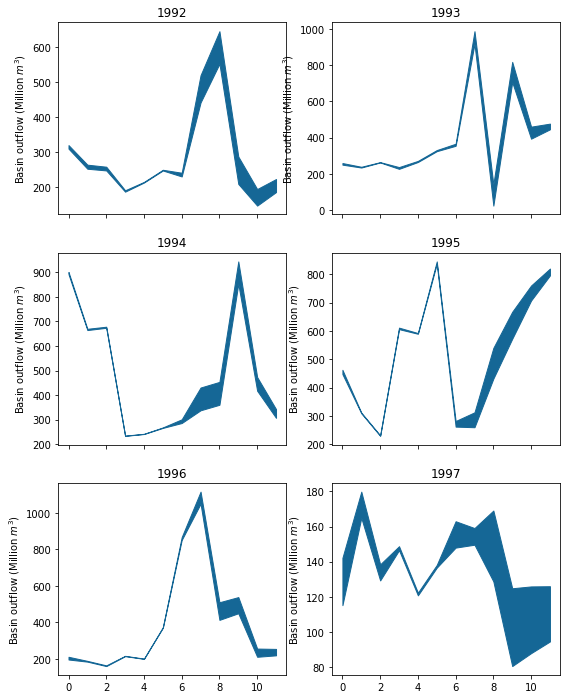

In [85]:
fig, axes = plt.subplots(ncols=2,nrows=3, sharex=True, figsize=(9,12))
flows = np.reshape(df_slim['original_flow'].values, (int(len(df_slim)/n_files),n_files))
mean_flows = np.mean(flows,axis=1)
for i, ax in enumerate(axes.flat):
    ax.fill_between(np.arange(12), max_flows[i*12:i*12+12]/1000000, min_flows[i*12:i*12+12]/1000000, color='#156796')
    #ax.plot(np.arange(12), original_flows[i*12:i*12+12]/1000000, color='black', linewidth=2,)
    ax.set_title(np.arange(df_slim['year'].values.min(), df_slim['year'].values.max()+1)[i])
    ax.set_ylabel('Basin outflow (Million $m^3$)')
plt.savefig('flows.svg')

In [ ]:
flows = np.reshape(df_slim['original_flow'].values, (int(len(df_slim)/n_files),n_files))
mean_flows = np.mean(flows,axis=1)

In [ ]:
original_flows_reduced = original_flows[81:87, :]
np.shape(original_flows_reduced)